In [1]:
from tqdm.auto import tqdm
from sentence_transformers import evaluation
import torch 
import random
from transformers import BertModel
from transformers import BertTokenizer
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
import sklearn.model_selection
import sklearn
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, util

In [2]:
#seed setting 
torch.manual_seed(13)
random.seed(13)

In [3]:
#load data 
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTrainData.csv", sep="\t")
df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']

#TODO: do we need to make data tensors or does this happen when we call set_format() later on
#df["ground_truth"] = df["ground_truth"].apply(torch.tensor)

#[torch.tensor(gtList) for gtList in df["ground_truth"]]

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["ground_truth",  'text1', 'text2']].dropna()


(array([593., 189., 113., 139.,  75.,  98., 110.,  71.,  91., 197.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

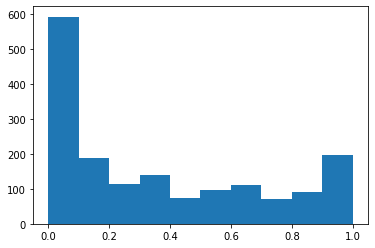

In [4]:
#check to make sure this is the right transformation to scale the data to (0, 1)
plt.hist(1 - ((leanDf["ground_truth"] - 1) / 3))

In [5]:
#rescale data from (0, 4): (0, 1)
leanDf["ground_truth"] = 1 - ((leanDf["ground_truth"] - 1) / 3)

(array([593., 189., 113., 139.,  75.,  98., 110.,  71.,  91., 197.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

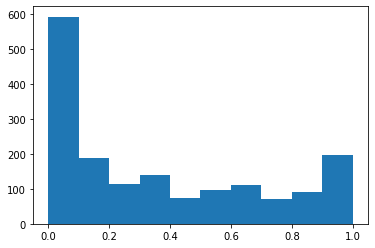

In [6]:
plt.hist(leanDf["ground_truth"])

In [7]:
print(df.shape)
print(len(df["link1"].unique()))
print(len(df["link2"].unique()))

(1690, 20)
1684
1510


In [8]:
deviceNum = 4
def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [9]:
#split data 
trainDf, validDf = sklearn.model_selection.train_test_split(leanDf, train_size=.75, test_size=.25, random_state=13)
trainDf = trainDf.reset_index(drop=True)
trainDf.head(2)

,ground_truth,text1,text2
0,0.666667,"Ayodeji Ake, Sunday Ehigiator and Chiamaka Ozu...",Former Vice President Atiku Abubakar has descr...
1,0.111111,Sign up to FREE daily email alerts from devonl...,The Exeter Chiefs are one of the great stories...


In [10]:
print("Train Rows: " + str(trainDf.shape[0]))
print("Validation Rows: "  + str(validDf.shape[0]))

Train Rows: 1257
Validation Rows: 419


In [11]:
trainExamples = []
for row in trainDf.itertuples(): 
    trainExamples.append(InputExample(texts =[row[2], row[3]], label=row[1]))

In [12]:
#Define the model. Either from scratch of by loading a pre-trained model
#del model 
torch.cuda.empty_cache()

#del(model)

model = SentenceTransformer('all-mpnet-base-v2', device="cuda:" + str(deviceNum))

#Define your train examples. You need more than just two examples...
#train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
#    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]

#Define your train dataset, the dataloader and the train loss
train_dataloader = torch.utils.data.DataLoader(trainExamples, shuffle=True, batch_size=5)

#works OK 
#train_loss = losses.MultipleNegativesRankingLoss(model)

train_loss = losses.CosineSimilarityLoss(model)

evaluator = evaluation.EmbeddingSimilarityEvaluator(list(validDf["text1"]), list(validDf["text2"]), list(validDf["ground_truth"]))

check_mem()

#Tune the model
#"/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTstockEval"
output_path = "/home/blitt/projects/localNews/models/sentEmbeddings/0.0-mpNetCosSim/output"
checkpoint_path = "/home/blitt/projects/localNews/models/sentEmbeddings/0.0-mpNetCosSim/checkpoint"
evaluation_steps = 50
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, warmup_steps=75, evaluator=evaluator, evaluation_steps = evaluation_steps, output_path=output_path, checkpoint_path=checkpoint_path, save_best_model=True)

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

In [13]:
evalData = pd.read_csv("/home/blitt/projects/localNews/models/sentEmbeddings/0.0-mpNetCosSim/output/eval/similarity_evaluation_results.csv")

In [14]:
evalData

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,50,0.859456,0.821652,0.862528,0.821652,0.861862,0.818631,0.859456,0.821652
1,0,100,0.865983,0.823925,0.867055,0.823925,0.867717,0.823891,0.865983,0.823925
2,0,150,0.867141,0.822692,0.869201,0.822692,0.869825,0.823449,0.867141,0.822692
3,0,200,0.869118,0.817192,0.868452,0.817192,0.868685,0.819469,0.869118,0.817192
4,0,250,0.870772,0.826758,0.871081,0.826758,0.871968,0.830962,0.870772,0.826758
5,0,-1,0.871915,0.828678,0.872133,0.828678,0.872950,0.832737,0.871915,0.828678
6,1,50,0.874292,0.836782,0.873481,0.836782,0.874229,0.838016,0.874292,0.836782
7,1,100,0.874481,0.836805,0.873950,0.836805,0.874413,0.837610,0.874481,0.836805
8,1,150,0.874896,0.835231,0.872498,0.835231,0.872957,0.837537,0.874896,0.835231
9,1,200,0.875030,0.834559,0.871991,0.834559,0.872648,0.837166,0.875030,0.834559


<ipython-input-15-af30dcb78274>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotData["totalSteps"] = totalSteps


Text(0, 0.5, 'Pearson Correlation')

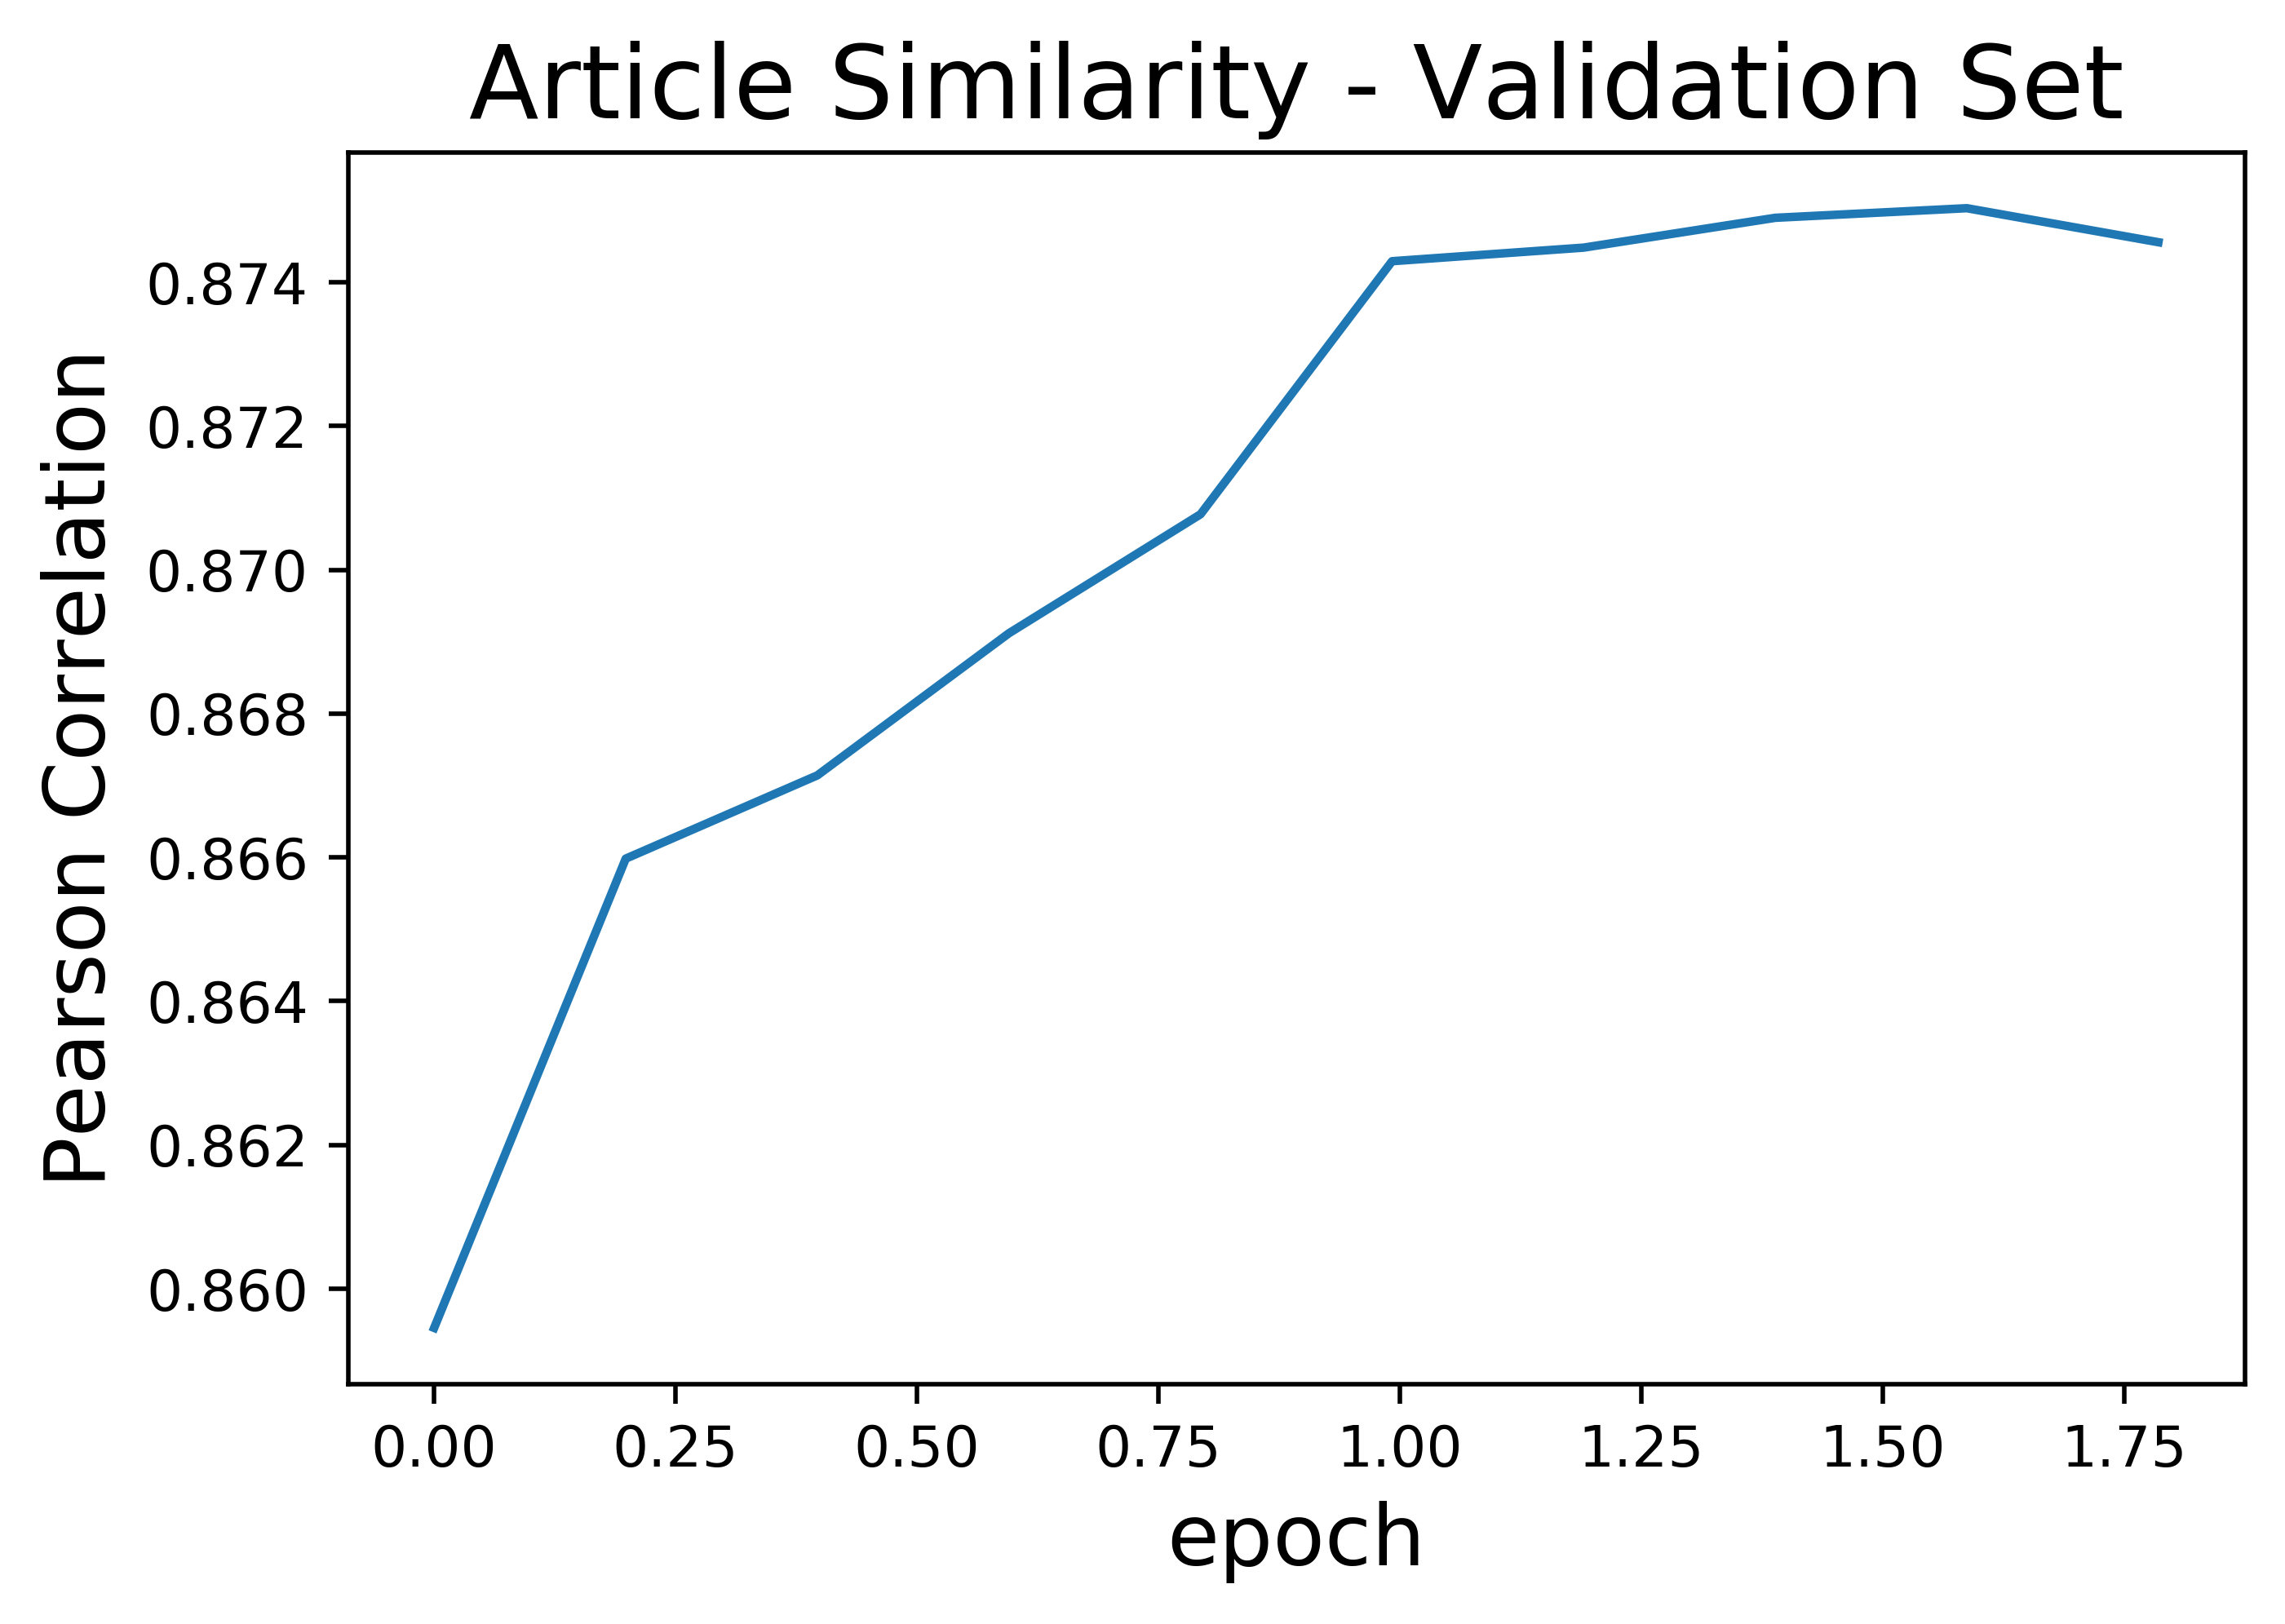

In [15]:
#format the data in dataframe 
plotData = evalData[evalData["steps"] != -1]
currStep = 0 
evaluation_steps = 50 
totalSteps = []
for i in range(len(plotData)):
    totalSteps.append(currStep)
    currStep += evaluation_steps 
    
plotData["totalSteps"] = totalSteps

#plot eval 
plt.rcParams['figure.dpi'] = 500
plt.plot(plotData["totalSteps"] / 252, plotData["cosine_pearson"])
plt.title("Article Similarity - Validation Set", size=18)
plt.xlabel("epoch", size=15)
plt.ylabel("Pearson Correlation", size=15)

In [16]:
#get test data 
testRow = validDf.reset_index(drop=True).iloc[0,:]
testExample = InputExample(texts = [testRow[1], testRow[2]], label=testRow[0])
testDf = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTestData.csv", sep="\t")
testDf.head(1)
print(testDf.shape)

(234, 19)


In [17]:
#load model
modelPath = "/home/blitt/projects/localNews/models/sentEmbeddings/0.0-mpNetCosSim/output"
model = SentenceTransformer(modelPath)

#compute embeddings for the test data and get correlation with ground truth 
text1 = list(testDf["text1"])
text2 = list(testDf["text2"])

#embed test text 
embed1 = model.encode(text1)
embed2 = model.encode(text2)

#get our cosine sims 
cos_scores = [] 
for i in range(len(embed1)): 
    cos_scores.append(util.cos_sim(embed1[i], embed2[i]))
cos_scores[:2]

#rescale ground truth 
preds = [float(item) for item in cos_scores]
gt = (5 - testDf["Overall"]) / 4
np.corrcoef([preds, gt])

#to dataframe 
comparisonMat = pd.DataFrame({"gt":gt, "preds":preds})

#create cutoff and get predictions/gt for binary classification problem 
cutoff = .6
comparisonMat["gtIsSame"] = comparisonMat["gt"] >= .9
comparisonMat["gtIsSame"] = comparisonMat["gtIsSame"].astype(int)

comparisonMat["predIsSame"] = comparisonMat["preds"] >= .9
comparisonMat["predIsSame"] = comparisonMat["predIsSame"].astype(int)
comparisonMat

,gt,preds,gtIsSame,predIsSame
0,0.375,-0.008745,0,0
1,1.000,0.666870,1,0
2,0.250,-0.041409,0,0
3,0.875,0.759550,0,0
4,0.250,0.113016,0,0
...,...,...,...,...
229,0.250,-0.031120,0,0
230,1.000,0.796463,1,0
231,0.750,0.594694,0,0
232,0.750,0.739325,0,0


In [28]:
withPred = pd.merge(testDf.reset_index(), comparisonMat.reset_index(), how="inner", on="index")
falsePos = withPred.loc[(withPred["gt"] < .6) & ( withPred["preds"] > .75), ["gt", "preds", "text1", "text2"]]

In [39]:
list(falsePos["text1"])[1]

'The BSE benchmark Sensex crashed by nearly 788 points and the NSE Nifty tumbled around 234 points on Monday as heightened tensions in the Middle East kept investors on edge.\n\nThe 30-share BSE index ended at 40,676.63, dropping of 787.98 points, or 1.90%. Similarly, the broader Nifty closed at 11,993.05, falling by 233.60 points, or 1.91%.\n\nOn the Sensex chart, Bajaj Finance was the top loser, dropping 4.63%, followed by SBI, IndusInd Bank, Maruti, HDFC, Hero MotoCorp, Axis Bank, ICICI Bank and Reliance Industries. Bucking the broader trend, only Titan and PowerGrid ended with gains.\n\nDomestic market witnessed intense selloff in line with global stocks after U.S. President Donald Trump warned Iran of major retaliation if Tehran carries out any attack against America to avenge the killing of top military commander Qasem Soleimani and hinted at striking its cultural sites. His statement came hours after Iran announced it will no longer abide by the limits contained in the 2015 land

In [41]:
list(falsePos["text1"])[1]

'The BSE benchmark Sensex crashed by nearly 788 points and the NSE Nifty tumbled around 234 points on Monday as heightened tensions in the Middle East kept investors on edge.\n\nThe 30-share BSE index ended at 40,676.63, dropping of 787.98 points, or 1.90%. Similarly, the broader Nifty closed at 11,993.05, falling by 233.60 points, or 1.91%.\n\nOn the Sensex chart, Bajaj Finance was the top loser, dropping 4.63%, followed by SBI, IndusInd Bank, Maruti, HDFC, Hero MotoCorp, Axis Bank, ICICI Bank and Reliance Industries. Bucking the broader trend, only Titan and PowerGrid ended with gains.\n\nDomestic market witnessed intense selloff in line with global stocks after U.S. President Donald Trump warned Iran of major retaliation if Tehran carries out any attack against America to avenge the killing of top military commander Qasem Soleimani and hinted at striking its cultural sites. His statement came hours after Iran announced it will no longer abide by the limits contained in the 2015 land

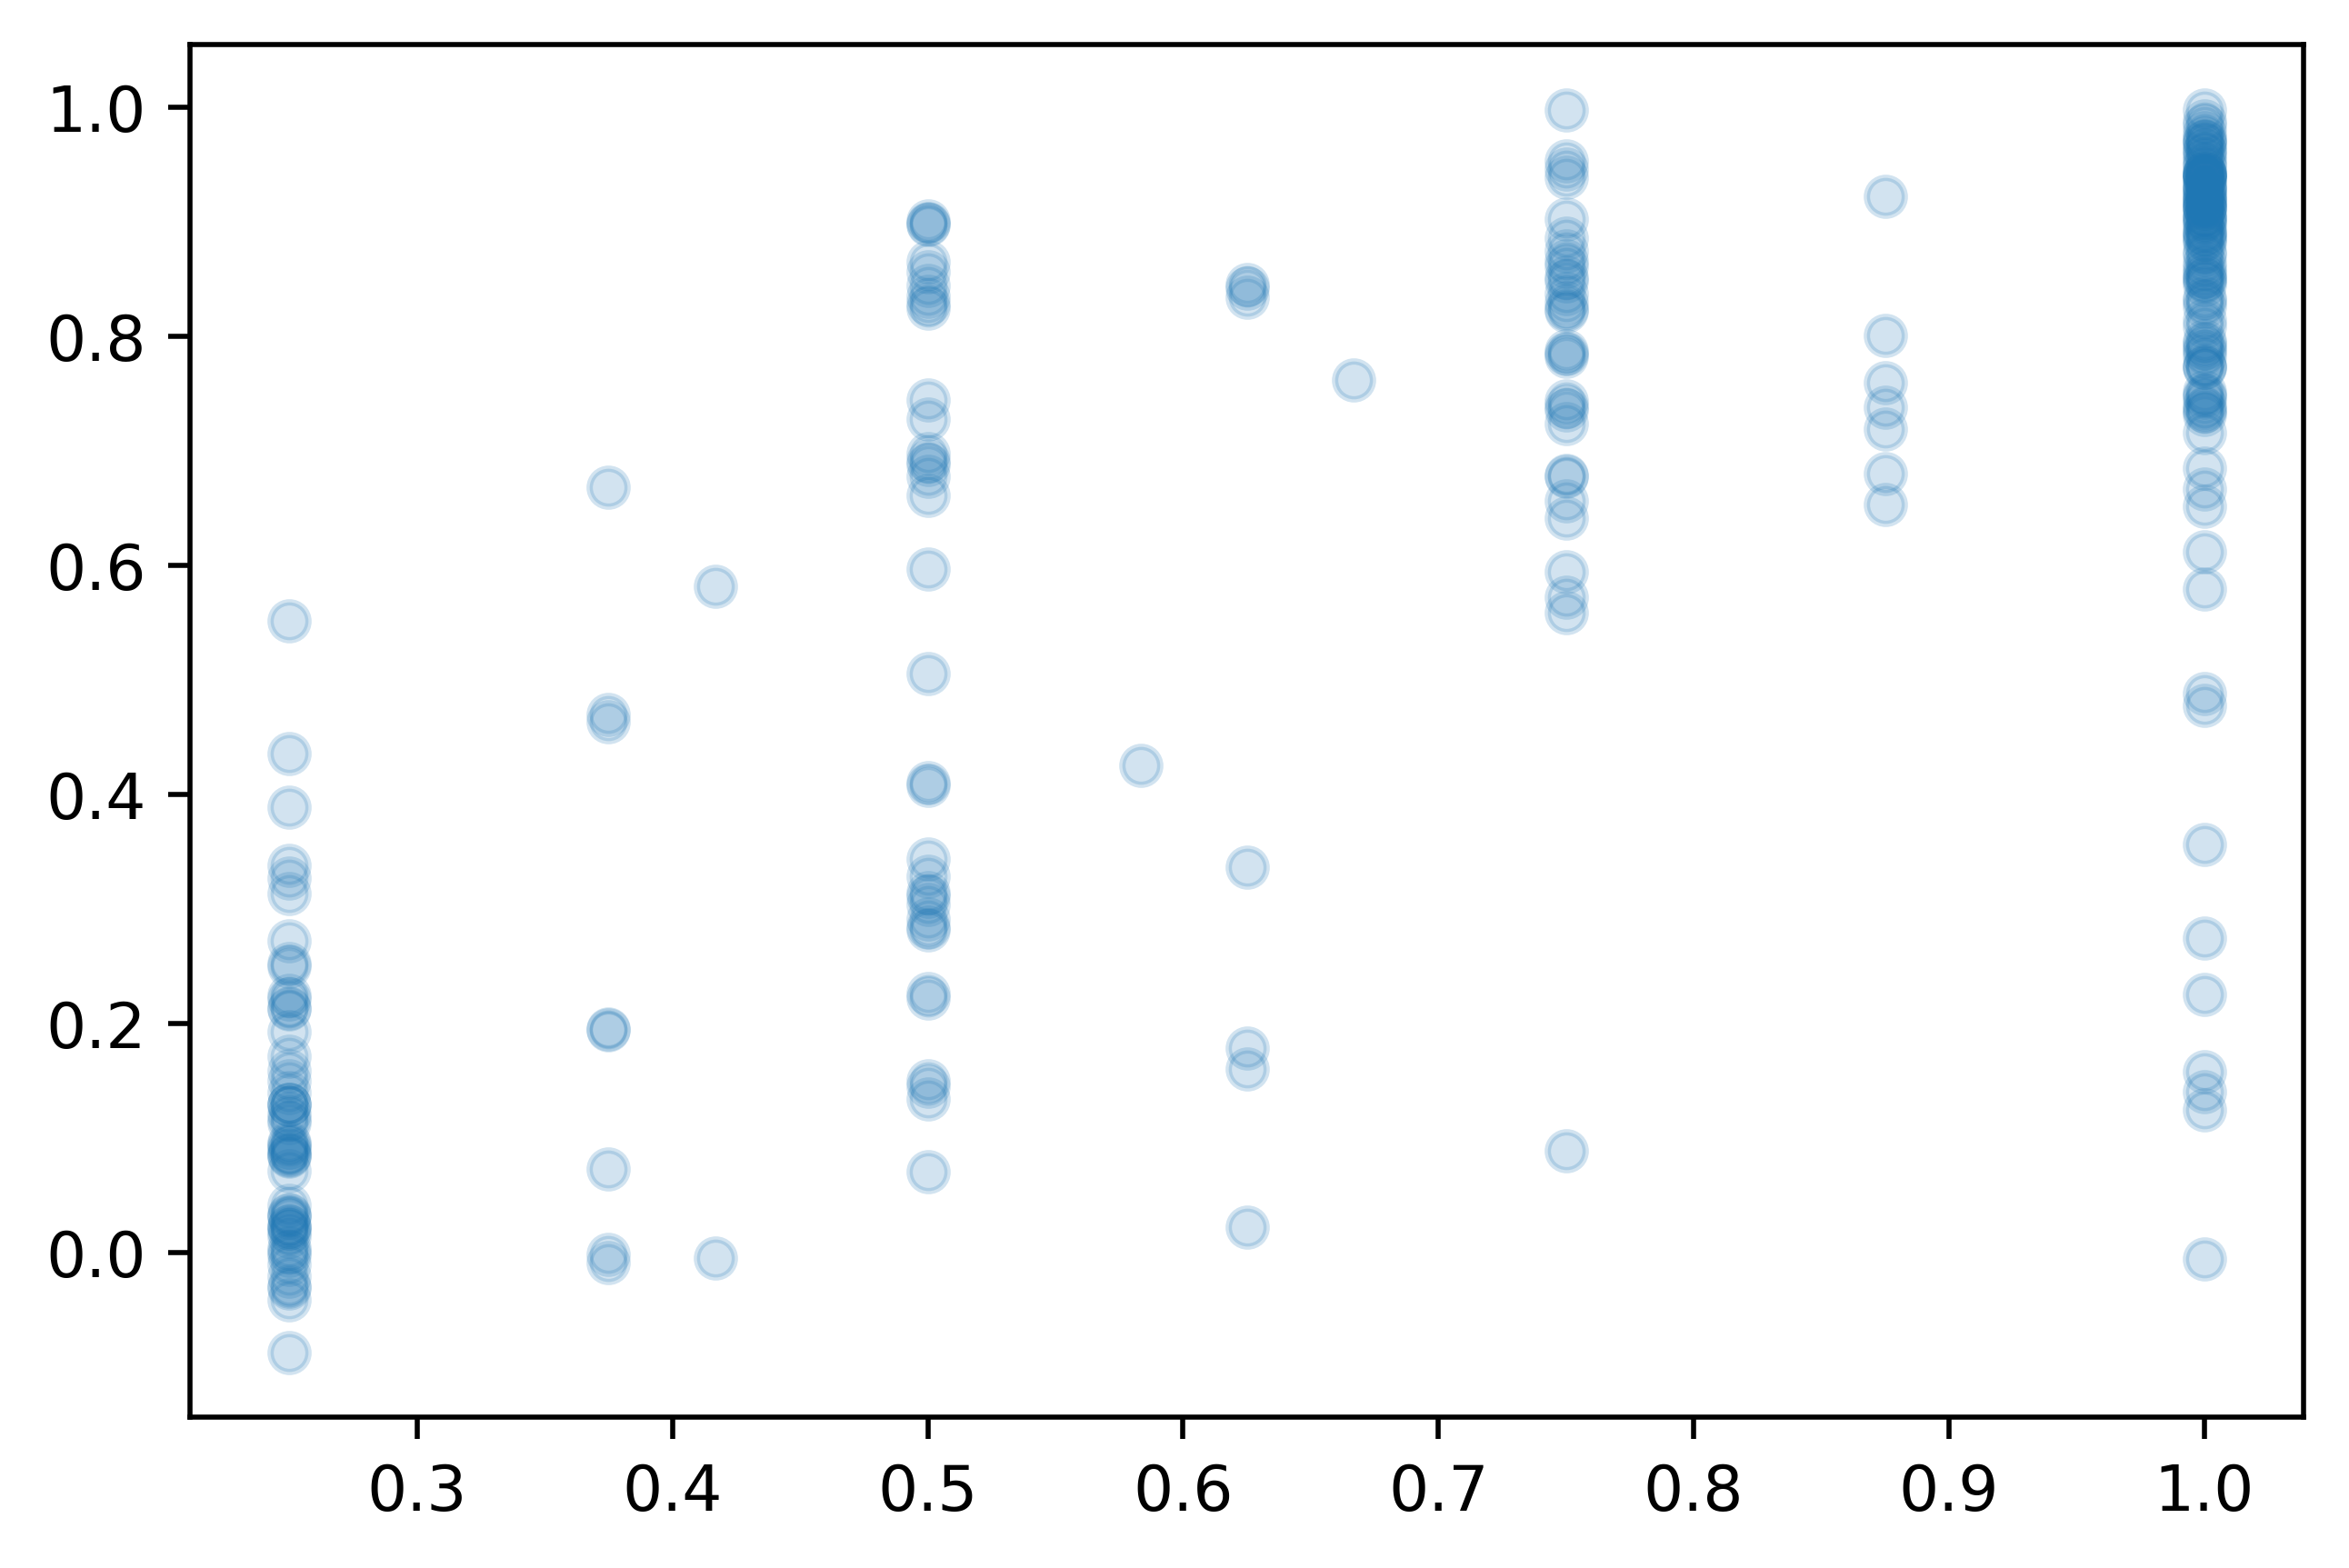

In [18]:
#compare ground truth on x axis to predictions on the y 
plt.scatter(comparisonMat["gt"], comparisonMat["preds"], alpha = .2)


Text(0, 0.5, 'Count')

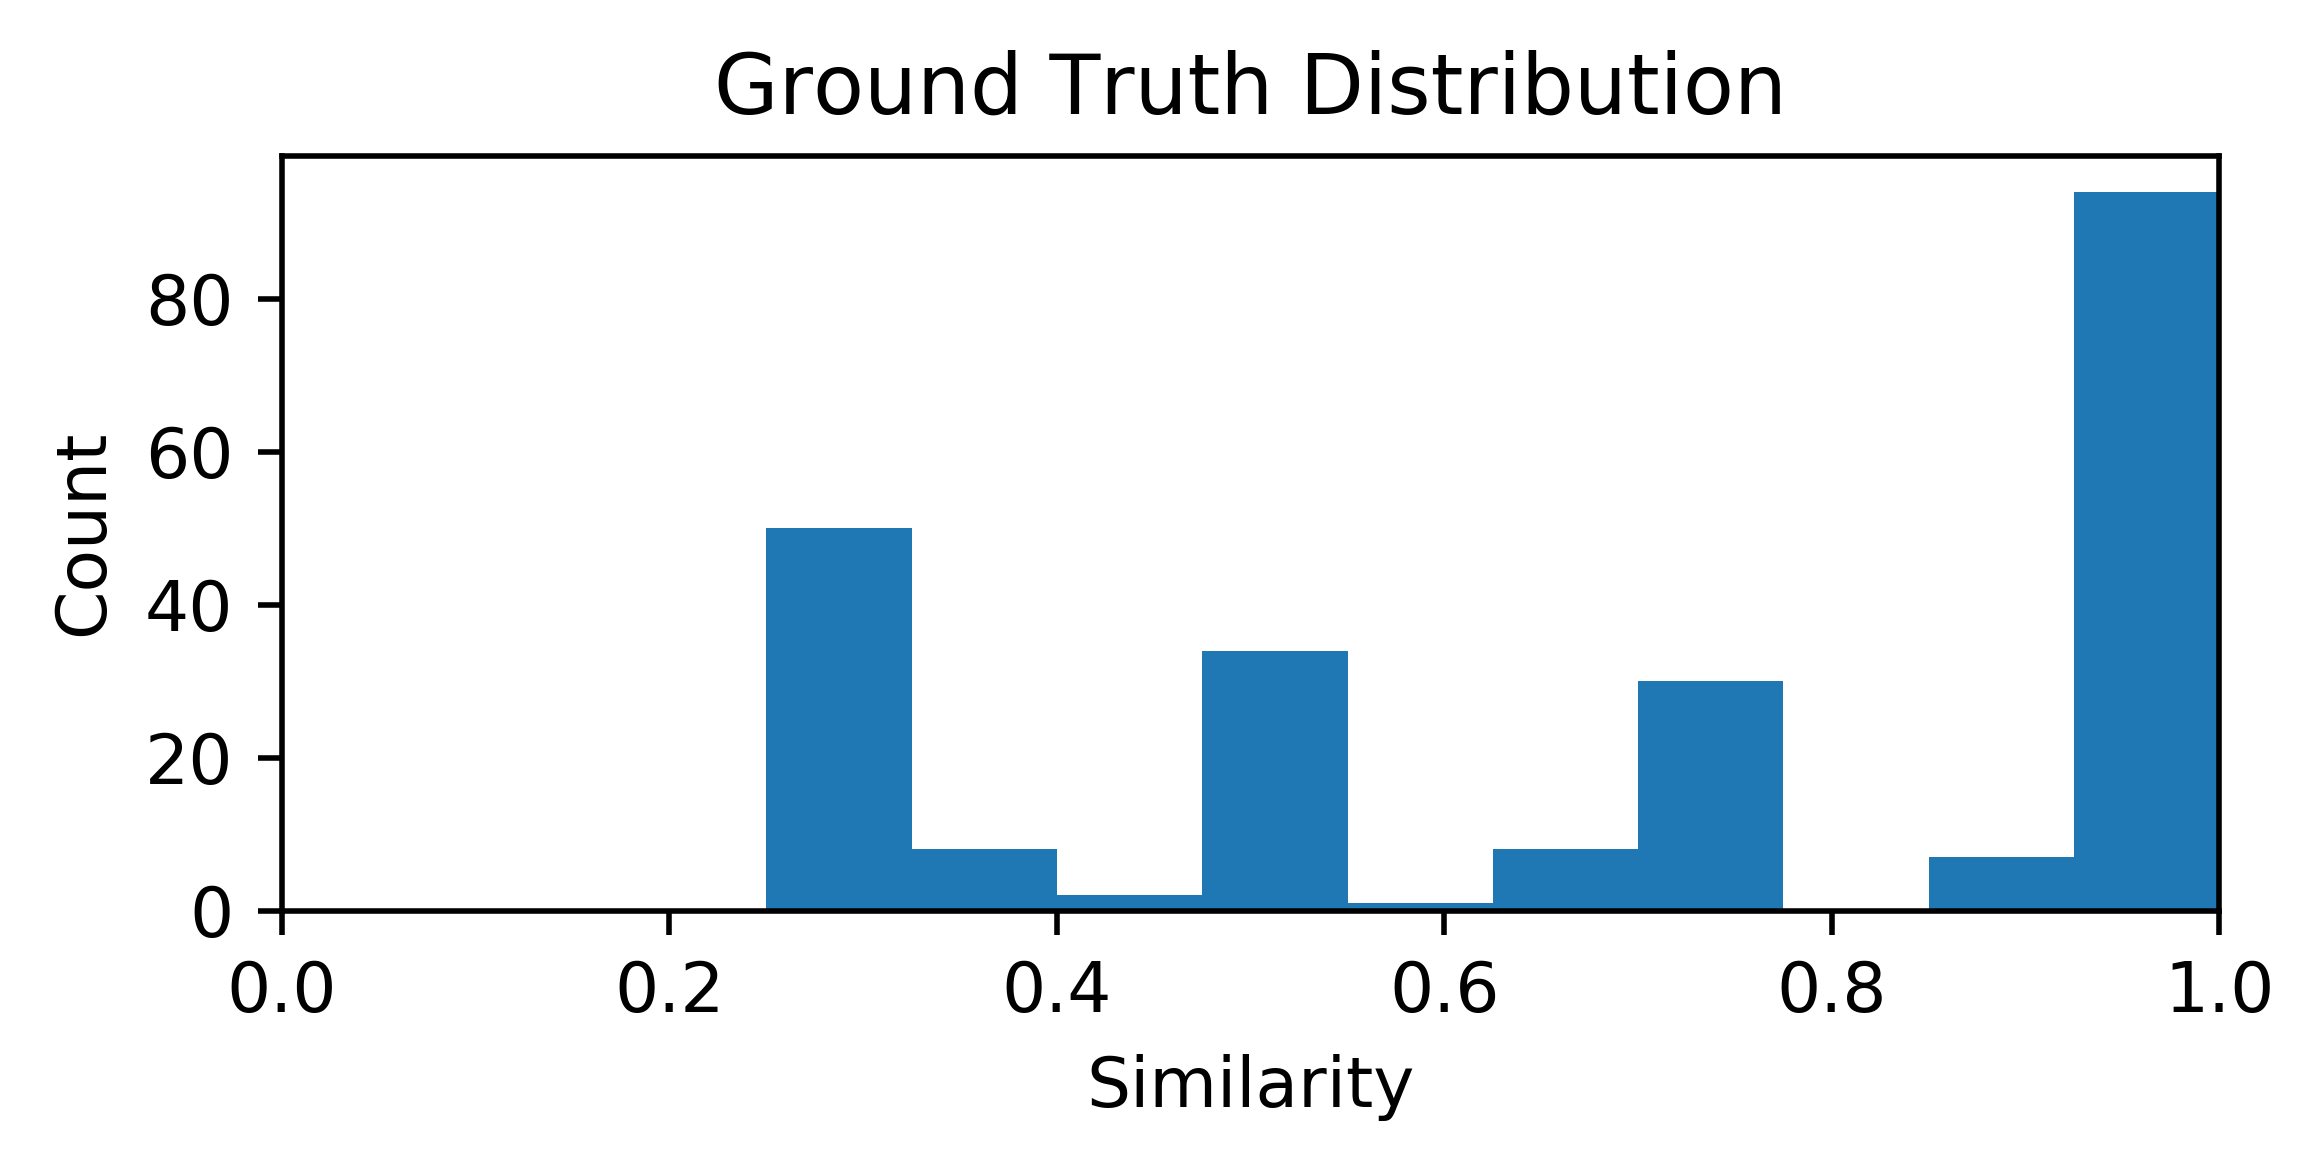

In [19]:
fig, ax = plt.subplots(figsize=[5, 2])
plt.hist(comparisonMat["gt"])
plt.title("Ground Truth Distribution")
plt.xlim([0, 1])
plt.xlabel("Similarity")
plt.ylabel("Count")

In [20]:
#confusion matrix 
conf = sklearn.metrics.confusion_matrix(comparisonMat["gtIsSame"], comparisonMat["predIsSame"])

#unpack conf matrix. Get accuracy 
acc = (conf[0,0] + conf[1, 1] ) / (len(comparisonMat))
tn, fp, fn, tp = conf.ravel()

#get precision, recall, f1
precision = (tp) / (tp + fp)
print("precision: " + str(precision))
recall = (tp) / (tp + fn)
print("recall: " + str(recall))
f1 = 2 * (precision * recall) / (precision + recall)
print("f1: " + str(f1))

precision: 0.8571428571428571
recall: 0.44680851063829785
f1: 0.5874125874125874
